# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 100)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', header='infer', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', header='infer', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 100)
print(azdias.shape)
azdias.head(n=11)


(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [4]:
azdias.describe(include='all')

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073,798073.000000,792242,792242,792242,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,10,45,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,8,6B,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,629528,NaN,134441,56672,133694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,NaN,4.052836,NaN,NaN,NaN,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699

In [5]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ARBEIT,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
# I found that feature summary file contains list of missing or unknown values for the columns
#The challange is the varying missin or unknown value flags.
#for (i,z) in azdias.iteritems():
#print(i, sum(z))
#Following code lists null cells but there is also missing/unknown values in cells which needs to be taken care of
azdias.isnull().sum().sum()    

4896838

In [7]:
#57,58,59 items contains X instead of 'X'
#replace(',X]', ",'X']").replace('XX',"'XX'")
print(feat_info['missing_or_unknown'][57])
print(feat_info['missing_or_unknown'][58])
print(feat_info['missing_or_unknown'][59])

[-1,X]
[XX]
[-1,XX]


In [8]:
feat_info['missing_or_unknown'][57]=str(feat_info['missing_or_unknown'].tolist()[57]).replace(',X]', ",'X']")
feat_info['missing_or_unknown'][58]=str(feat_info['missing_or_unknown'].tolist()[58]).replace('XX', "'XX'")
feat_info['missing_or_unknown'][59]=str(feat_info['missing_or_unknown'].tolist()[59]).replace('XX', "'XX'")

In [9]:
print(feat_info['missing_or_unknown'][57])
print(feat_info['missing_or_unknown'][58])
print(feat_info['missing_or_unknown'][59])

[-1,'X']
['XX']
[-1,'XX']


In [10]:
azdias_clean=azdias.copy()

In [11]:
feat_info.head(n=10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [12]:
feat_info_clean = feat_info.copy()

In [13]:
feat_info_clean = feat_info_clean.set_index('attribute')

In [14]:
feat_info_clean

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]
FINANZ_SPARER,person,ordinal,[-1]
FINANZ_VORSORGER,person,ordinal,[-1]
FINANZ_ANLEGER,person,ordinal,[-1]
FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]


In [15]:
feat_info_cleaner = []

In [16]:
import ast
for cols in feat_info_clean.index:
    feat_info_cleaner.append(ast.literal_eval(feat_info_clean.loc[cols].loc['missing_or_unknown']))

In [17]:
#Check list output
feat_info_cleaner[1]

[-1, 0, 9]

In [18]:
#replace missing values that are not empty (size!=0)
for indx in range(len(feat_info_cleaner)):
    if np.size(feat_info_cleaner[indx]) !=0:
        azdias_clean.iloc[:,indx].replace(feat_info_cleaner[indx],np.nan, inplace=True)

In [19]:
#Help page indicates there are 8,373,929 NaNs, check that is it is true
print('Total number of NaNs is {}'.format(azdias_clean.isna().sum().sum()))

Total number of NaNs is 8373929


In [20]:
#Write the clean dataset as a checkpoint
azdias_clean.to_csv('azdias_cleaned.csv', index=False)

In [21]:
azdias_clean = pd.read_csv('azdias_cleaned.csv')

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([  5.99243000e+05,   1.32881000e+05,   5.12210000e+04,
          1.16220000e+04,   2.63300000e+03,   4.35000000e+02,
          7.45500000e+03,   1.15020000e+04,   7.04000000e+02,
          7.35250000e+04]),
 array([  0. ,   5.4,  10.8,  16.2,  21.6,  27. ,  32.4,  37.8,  43.2,
         48.6,  54. ]),
 <a list of 10 Patch objects>)

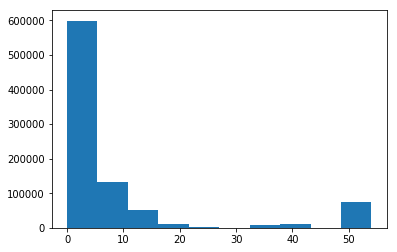

In [22]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.hist(azdias_clean.isna().sum(axis=1))

In [23]:
#summary of column NAs
na_counts=[]
for cols in range(len(azdias_clean.columns)):
    na_counts.append([list(azdias_clean.columns)[cols], azdias_clean.iloc[:,cols].isna().sum()])
na_df=pd.DataFrame(na_counts)
na_df.columns=['Columns','NA_count']
na_df.sort_values('NA_count',ascending=False)

,Columns,NA_count
40,TITEL_KZ,889061
0,AGER_TYP,685843
47,KK_KUNDENTYP,584612
64,KBA05_BAUMAX,476524
11,GEBURTSJAHR,392318
43,ALTER_HH,310267
70,KKK,158064
73,REGIOTYP,158064
48,W_KEIT_KIND_HH,147988
60,KBA05_ANTG1,133324


In [24]:
# Investigate patterns in the amount of missing data in each column.

#I build a matrix just for NAs to analyze correlation between NAs.
#there are several 0 NA columns which shouldn't stay in the correlation analysis in the next section otherwise they will show as NA
na_matrix= azdias_clean.copy()
na_matrix = na_matrix.isnull().astype(int)
na_matrix.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.0,891221.000000,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.000000,891221.000000,891221.0,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.0,891221.000000,891221.00000,891221.000000,891221.000000,891221.0,891221.000000,891221.00000,891221.00000,891221.000000,891221.000000,891221.000000,891221.00000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,0.769554,0.003233,0.0,0.005446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440203,0.005446,0.0,0.124768,0.109549,0.106115,0.087287,0.087287,0.005446,0.005446,0.121536,0.121366,0.005446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124768,0.08247,0.997576,0.124768,0.0,0.348137,0.08247,0.08247,0.020587,0.655967,0.166051,0.08247,0.111769,0.108848,0.104517,0.082997,0.104517,0.104517,0.104517,0.111479,0.111479,0.111479,0.149597,0.149597,0.149597,0.149597,0.534687,0.149597,0.105182,0.105182,0.105182,0.104525,0.177357,0.149597,0.005446,0.177357,0.118714,0.130736,0.130736,0.130736,0.130736,0.130736,0.130736,0.130736,0.109260,0.109147,0.109260
std,0.421118,0.056764,0.0,0.073599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.496412,0.073599,0.0,0.330456,0.312326,0.307985,0.282255,0.282255,0.073599,0.073599,0.326749,0.326552,0.073599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.330456,0.27508,0.049171,0.330456,0.0,0.476380,0.27508,0.27508,0.141999,0.475052,0.372126,0.27508,0.315082,0.311449,0.305931,0.275878,0.305931,0.305931,0.305931,0.314724,0.314724,0.314724,0.356676,0.356676,0.356676,0.356676,0.498796,0.356676,0.306787,0.306787,0.306787,0.305941,0.381970,0.356676,0.073599,0.381970,0.323451,0.337112,0.337112,0.337112,0.337112,0.337112,0.337112,0.337112,0.311966,0.311824,0.311966
min,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [25]:
#Let's see which colums have largest missing values
na_matrix.describe().loc['mean',:].nlargest(10)

TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
KKK               0.177357
REGIOTYP          0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG1       0.149597
Name: mean, dtype: float64

In [26]:
#Following code will create a clean na matrix where it drops columns without NAs
#There are 61 columns with NAs, TOP 5 NA columns are as shown above:
#TITEL_KZ (academic title),AGER_TYP (ager typology), KK_KUNDENTYPE (consumer pattern last 12 months)
#KBA05_BAUMAX (most common building type within the microcell) GEBURTSJAHR (Birth Year)
na_matrix_clean = na_matrix.copy()
na_matrix_clean = na_matrix_clean.loc[:,(na_matrix_clean.mean()!=0)]
na_matrix_clean.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,GEBURTSJAHR,GFK_URLAUBERTYP,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.00000,891221.000000,891221.000000,891221.000000,891221.00000,891221.00000,891221.000000,891221.000000,891221.000000,891221.00000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,0.769554,0.003233,0.005446,0.440203,0.005446,0.124768,0.109549,0.106115,0.087287,0.087287,0.005446,0.005446,0.121536,0.121366,0.005446,0.124768,0.08247,0.997576,0.124768,0.348137,0.08247,0.08247,0.020587,0.655967,0.166051,0.08247,0.111769,0.108848,0.104517,0.082997,0.104517,0.104517,0.104517,0.111479,0.111479,0.111479,0.149597,0.149597,0.149597,0.149597,0.534687,0.149597,0.105182,0.105182,0.105182,0.104525,0.177357,0.149597,0.005446,0.177357,0.118714,0.130736,0.130736,0.130736,0.130736,0.130736,0.130736,0.130736,0.109260,0.109147,0.109260
std,0.421118,0.056764,0.073599,0.496412,0.073599,0.330456,0.312326,0.307985,0.282255,0.282255,0.073599,0.073599,0.326749,0.326552,0.073599,0.330456,0.27508,0.049171,0.330456,0.476380,0.27508,0.27508,0.141999,0.475052,0.372126,0.27508,0.315082,0.311449,0.305931,0.275878,0.305931,0.305931,0.305931,0.314724,0.314724,0.314724,0.356676,0.356676,0.356676,0.356676,0.498796,0.356676,0.306787,0.306787,0.306787,0.305941,0.381970,0.356676,0.073599,0.381970,0.323451,0.337112,0.337112,0.337112,0.337112,0.337112,0.337112,0.337112,0.311966,0.311824,0.311966
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

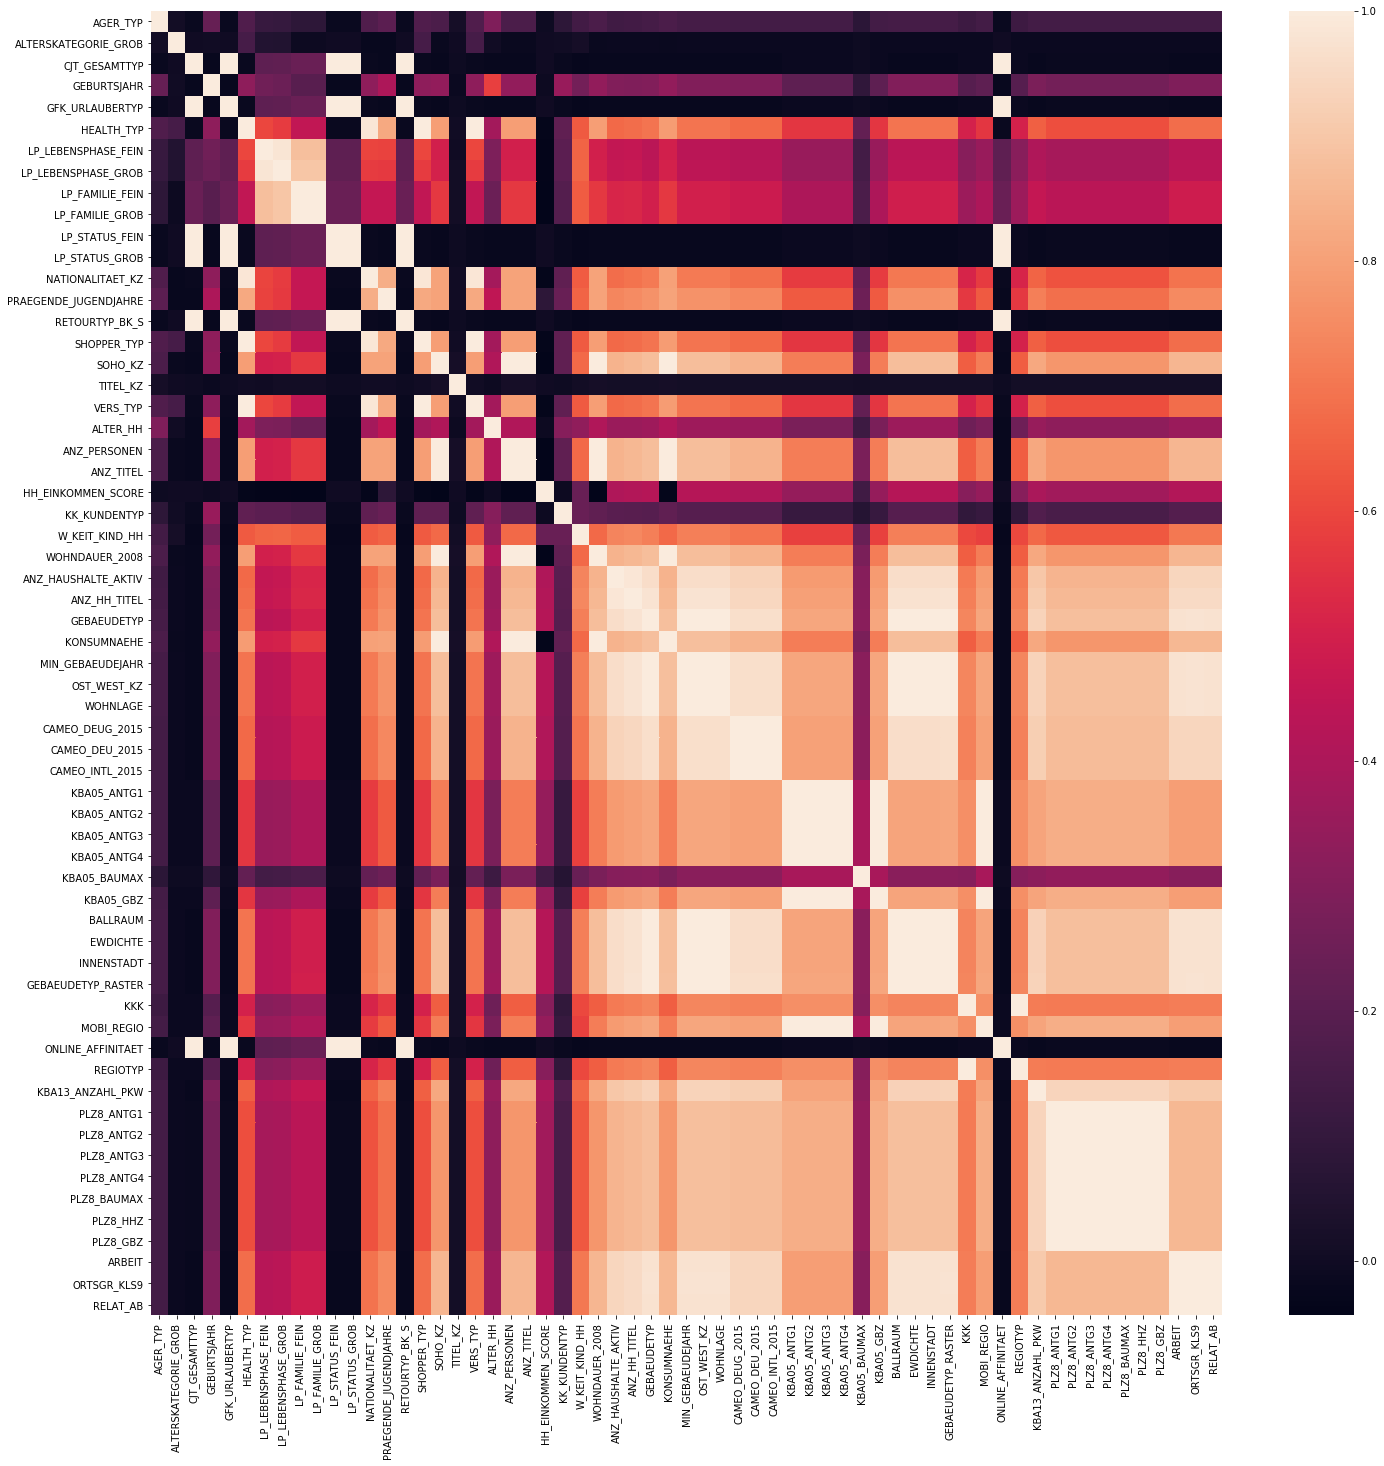

In [27]:
#AS correlation plot for missing values show that there are certain variables which are highly correlated 
#whereas others not correlated in chunks (mostly exhaustive variables).
plt.figure(figsize=(24,24))
sns.heatmap(na_matrix_clean.corr(method='pearson'))

In [28]:
#I also pulled 10 largest correlation for each column in the missing val matrix
#As expected, when a level has a missing value, it is positively associated that other columns in the same level is also NA
#One of the reason for this is the fact that several columns are exhaustive in nature to describe certain attributes. 
#As a result, they either coded together/available or missing together
corr = na_matrix_clean.corr()
for cols in corr:
    print(corr.loc[:,cols].abs().nlargest(10))

AGER_TYP                 1.000000
ALTER_HH                 0.291346
GEBURTSJAHR              0.231987
PRAEGENDE_JUGENDJAHRE    0.203380
NATIONALITAET_KZ         0.174855
HEALTH_TYP               0.173860
SHOPPER_TYP              0.173860
VERS_TYP                 0.173860
SOHO_KZ                  0.164060
ANZ_PERSONEN             0.164060
Name: AGER_TYP, dtype: float64
ALTERSKATEGORIE_GROB     1.000000
HEALTH_TYP               0.150831
SHOPPER_TYP              0.150831
VERS_TYP                 0.150831
LP_LEBENSPHASE_FEIN      0.053821
LP_LEBENSPHASE_GROB      0.048090
NATIONALITAET_KZ         0.021182
PRAEGENDE_JUGENDJAHRE    0.020802
KONSUMNAEHE              0.017133
SOHO_KZ                  0.017073
Name: ALTERSKATEGORIE_GROB, dtype: float64
CJT_GESAMTTYP          1.000000
GFK_URLAUBERTYP        1.000000
LP_STATUS_FEIN         1.000000
LP_STATUS_GROB         1.000000
RETOURTYP_BK_S         1.000000
ONLINE_AFFINITAET      1.000000
LP_FAMILIE_FEIN        0.239296
LP_FAMILIE_GROB       

In [29]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Note that after KKK, NA percentage jumps to 34%. As a result 33% or worse missing values will be dropped from DF.
na_matrix.describe().loc['mean',:].nlargest(10)


TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
KKK               0.177357
REGIOTYP          0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG1       0.149597
Name: mean, dtype: float64

In [30]:
#drop followings, NAs larger than 32%
drop_columns=na_matrix.columns[na_matrix.describe().loc['mean',:]>=0.33]
print(drop_columns)

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [31]:
azdias_clean=azdias_clean.drop(columns = drop_columns, axis=1)

In [32]:
#final dataset for adjusting number of columns
#Also created another checkpoint
#azdias_clean.to_csv('azdias_cleaned_dropped.csv', index=False)
azdias_clean = pd.read_csv('azdias_cleaned_dropped.csv')
print(azdias_clean.shape)
azdias_clean.describe()

(891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,780025.000000,793589.000000,796649.000000,813429.000000,813429.000000,886367.000000,886367.000000,782906.000000,783057.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,780025.000000,817722.000000,780025.000000,891221.000000,817722.000000,817722.000000,872873.000000,743233.000000,817722.000000,791610.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,791869.000000,791869.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,733157.000000,757897.000000,886367.000000,733157.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,7.350304,0.196612,2.190129,16.332161,4.955185,3.922339,2.381976,4.791151,2.432575,1.168889,9.280709,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.590134,0.008423,1.511166,3.362438,1.727637,0.004162,4.207243,4.147141,7.908791,8.354924,0.040647,2.798641,3.018452,1993.277011,4.052836,5.537665,35.494010,1.494277,1.265584,0.624525,0.305927,3.158580,4.153043,3.939172,4.549491,3.738306,2.723384,2.963540,2.698691,4.472086,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,3.525723,0.397437,0.755213,12.242378,3.748974,3.941285,1.701527,3.425305,1.474315,0.475075,4.032107,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.027972,0.091392,0.499876,1.352704,1.155849,0.068855,1.624057,1.784211,1.923137,15.673731,0.324028,2.656713,1.550312,3.332739,1.949539,2.489830,14.030479,1.403961,1.245178,1.013443,0.638725,1.329537,2.183710,1.718996,2.028919,0.923193,0.979867,1.428882,1.521524,1.836357,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1985.000000,0.000000,1.000000,12.000000,0.000000,0.000000,0.00

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Note that I chose to drop 6 columns from dataset; ratio of  NAs to total rows are also shown next to column names.
TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0,0.5,'occurance')

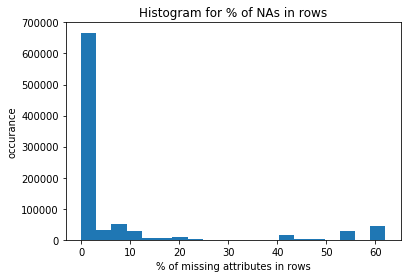

In [33]:
# How much data is missing in each row of the dataset?
n_missing_row = azdias_clean.isna().sum(axis=1)
prcnt_m_r = n_missing_row/len(azdias_clean.columns)*100
plt.hist(prcnt_m_r, bins=20)
plt.title('Histogram for % of NAs in rows')
plt.xlabel('% of missing attributes in rows')
plt.ylabel('occurance')

In [34]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
#My analysis show that 30% is a good threshold to divide the data.
#If 30% or more attributes are missing per row, it will be in low attribute subset.
#Note that 0.25*79=19.75; Hence, rows with 20 and more missing attributes will be at low attribute subset
low_attribute_subset = azdias_clean[prcnt_m_r>=20]
high_attribute_subset = azdias_clean[prcnt_m_r<20]
print("Low attribute subset contains ",len(low_attribute_subset), "rows or",round(len(low_attribute_subset)/len(azdias_clean)*100,2),"%")
print("High attribute subset contains ",len(high_attribute_subset), "rows or",round(len(high_attribute_subset)/len(azdias_clean)*100,2),"%")

Low attribute subset contains  98934 rows or 11.1 %
High attribute subset contains  792287 rows or 88.9 %


In [35]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
compare_attributes = ['FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER','GREEN_AVANTGARDE', 'ANREDE_KZ','ZABEOTYP' ]

In [36]:
#Let's first see how selected attributes varies within its own dataset
def plot_comparison(col_A, col_B, selected_columns):
    fg, axes = plt.subplots(nrows = len(selected_columns), ncols = 2, figsize = (12,12))
    fg.subplots_adjust(wspace = 0.5, hspace = 1)
    for i in range(len(selected_columns)):
        sns.countplot(col_A[selected_columns[i]], ax=axes[i][0])
        axes[i][0].set_title('Low_attribute_Subset')
        sns.countplot(col_B[selected_columns[i]], ax=axes[i][1])
        axes[i][1].set_title('High_attribute_Subset')

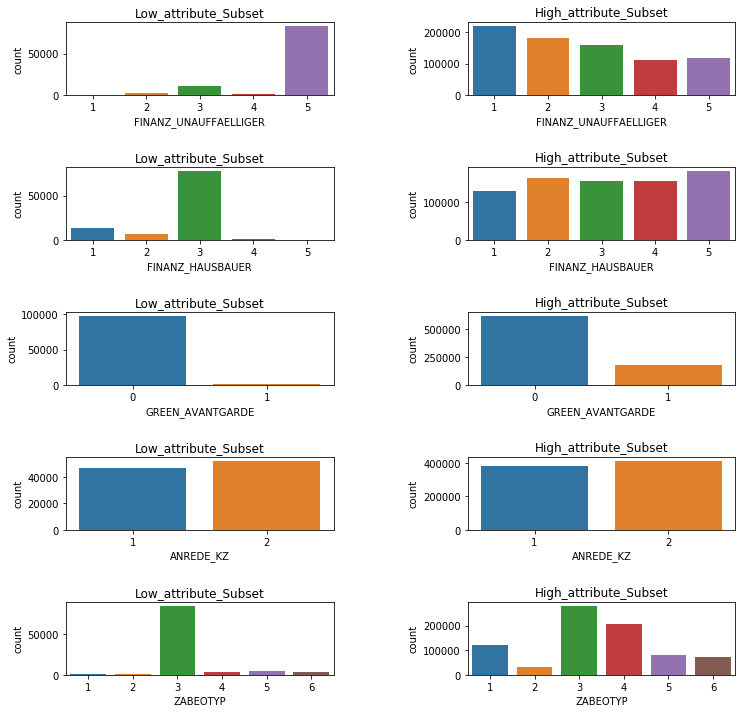

In [37]:
plot_comparison(low_attribute_subset[compare_attributes], high_attribute_subset[compare_attributes], compare_attributes)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

By looking at the charts, it becomes clear that low attribute subsample is not representative or not similar to the high attribute row subset, qualitatively different.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [38]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [39]:
# How many features are there of each data type?
feat_info.groupby(['type']).size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

In [41]:
#Although note that we dropped 6 columns, so cleaned dataset has following features, which shows I dropped 1 interval, 1 mixed and numberic and 3 categorical feature:
remaining_columns = azdias_clean.columns
feat_info_clean = feat_info[feat_info.attribute.isin(remaining_columns)]
feat_info_clean.groupby(['type']).size()

type
categorical    18
mixed           6
numeric         6
ordinal        49
dtype: int64

In [42]:
#Store feature column names for each category
categorical_attr = feat_info_clean.loc[feat_info_clean['type']=='categorical','attribute']
mixed_attr = feat_info_clean.loc[feat_info_clean['type']=='mixed','attribute']
numeric_attr = feat_info_clean.loc[feat_info_clean['type']=='numeric','attribute']
ordinal_attr = feat_info_clean.loc[feat_info_clean['type']=='ordinal','attribute']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [43]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
azdias_clean.loc[:,categorical_attr].describe()
#BINARY: ANREDE_KZ, GREEN_AVANTGARDE,SOHO_KZ, VERS_TYP,

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015
count,891221.000000,886367.000000,891221.000000,886367.000000,891221.000000,813429.000000,813429.000000,886367.000000,886367.000000,782906.000000,780025.000000,817722.000000,780025.000000,891221.000000,798073.000000,791869.000000
mean,1.522098,3.632838,3.790586,7.350304,0.196612,3.922339,2.381976,4.791151,2.432575,1.168889,1.590134,0.008423,1.511166,3.362438,2.798641,5.537665
std,0.499512,1.595021,1.987876,3.525723,0.397437,3.941285,1.701527,3.425305,1.474315,0.475075,1.027972,0.091392,0.499876,1.352704,2.656713,2.489830
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,2.000000,5.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,1.000000,3.000000
50%,2.000000,4.000000,4.000000,8.000000,0.000000,1.000000,1.000000,4.000000,2.000000,1.000000,2.000000,0.000000,2.000000,3.000000,1.000000,6.000000
75%,2.000000,5.000000,6.000000,10.000000,0.000000,8.000000,4.000000,9.000000,4.000000,1.000000,2.000000,0.000000,2.000000,4.000000,3.000000,8.000000
max,2.000000,6.000000,6.000000,12.000000,1.000000,11.000000,5.000000,10.000000,5.000000,3.000000,3.000000,1.000000,2.000000,6.000000,8.000000,9.000000


In [44]:
#We can find number of unique values per column as follow
azdias_clean[categorical_attr].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

BINARY: ANREDE_KZ, GREEN_AVANTGARDE,SOHO_KZ, VERS_TYP, OST_WEST_KZ
The non-numeric binary variable is OST_WEST_KZ: W stands for West, O stands for East; 
I replaced 0 with zero and W with 1 below, other binary variables require no modification.
MULTI-LEVEL: remaining 13 features in the categorical columns are multilevel.

In [45]:
# Re-encode categorical variable(s) to be kept in the analysis.
#First replace non-numeric characters
azdias_clean['OST_WEST_KZ'].replace(['O','W'],[0,1], inplace = True)

In [46]:
azdias_clean = azdias_clean.drop(columns=['LP_STATUS_FEIN','CAMEO_DEU_2015','CAMEO_DEUG_2015'], axis=1)

In [47]:
#Create dummy variables for multi-valued categorical columns
multilevel_clean = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_GROB','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP']

In [48]:
#Create a dummy creatior and related column dropper function
def dummy_creator(dummy_list, source):
    for i in dummy_list:
        dummy = pd.get_dummies(source[i], prefix=i, drop_first=True)
        source = source.join(dummy)
        source.drop([i], axis=1, inplace=True)
    return source

In [49]:
azdias_clean = dummy_creator(multilevel_clean, azdias_clean)

In [50]:
azdias_clean.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0
count,888340.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,780025.000000,793589.000000,796649.000000,813429.000000,783057.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,780025.000000,817722.000000,817722.000000,872873.000000,743233.000000,817722.000000,791610.000000,794213.000000,817252.000000,798073.000000,798073.000000,798073.000000,791869.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,733157.000000,757897.000000,886367.000000,733157.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,2.757217,1.522098,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,0.196612,2.190129,16.332161,4.955185,3.922339,9.280709,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,0.008423,1.511166,1.727637,0.004162,4.207243,4.147141,7.908791,8.354924,0.040647,3.018452,1993.277011,0.788810,4.052836,35.494010,1.494277,1.265584,0.624525,0.305927,3.158580,4.153043,3.939172,4.549491,3.738306,2.723384,2.963540,2.698691,4.472086,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033,0.166956,0.175545,0.236712,0.131702,0.172701,0.124399,0.059866,0.146569,0.119427,0.325808,0.052402,0.062843,0.071554,0.134788,0.030450,0.048199,0.098788,0.068012,0.122447,0.089473

In [51]:
#Checkpoint
#azdias_clean.to_csv('azdias_cleaned_categorical.csv', index=False)
azdias_clean = pd.read_csv('azdias_cleaned_categorical.csv')

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Note that micro-cell features represent lifestyle classifications based on different coding standards. 
Using multiple classifications in the same feature space will not improve the model much if not detoriate.
I also realized that there are ruough and detailed scales for similar measurements. 
Using both would not improve models much.
For simplicity, I dropped detailed scales and work with "rough scale"s whenever possible because many variables' combinations generate similar outcomes for the detailed sclaes anyway. If both are kept,this may only increase multicollinearity and reduce significance of variables.

Following columns dropped: LP_STATUS_FEIN, CAMEO_DEU_2015, CAMEO_DEUG_2015 (This last variable is a rough scale column but because I will use CAMEO_INTL_2015 for lifestyle space, no need to keep this column here)

Also, multilevel variables dummy coded for machine learning application

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#Example: 40s - war year (Mainstream, E+W)
#Generation by Decate: 40s = 45 as mid year
#Movement: Mainstream (coded as 0 for Mainstream, 1 if avantgarde)
#Nation: E+W =1; E = 0 ; of E only then E=1 W=0

decades_dict_keys=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, None]
decades_dict_vals =[45,45,55,55,65,65,65,75,75,85,85,85,85,95,95,None]
decade_dict = dict(zip(decades_dict_keys,decades_dict_vals))

movement_dict_keys=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,None]
movement_dict_vals =[0,1,0,1,0,1,1,0,1,0,1,0,1,0,1, None]
movement_dict = dict(zip(movement_dict_keys,movement_dict_vals))


In [53]:
#create youth decade column from respective dict
azdias_clean['youth_decade']= azdias_clean['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)

In [54]:
#create youth movement column from respective dict
azdias_clean['youth_movement']= azdias_clean['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)

In [55]:
#Drop PRAEGENDE_JUGENDJAHRE
azdias_clean.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [56]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 
#Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
#which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
# Ex: 11: Wealthy Households - Pre-Family Couples & Singles
# Ex: 55: Poorer Households - Elders In Retirement


azdias_clean['wealth'] = [int(str(val)[0]) if not np.isnan(val) else np.nan for val in azdias_clean['CAMEO_INTL_2015']]
azdias_clean['life_stage'] = [int(str(val)[1]) if not np.isnan(val) else np.nan for val in azdias_clean['CAMEO_INTL_2015']]



In [57]:
azdias_clean['wealth'].describe()

count    791869.000000
mean          3.262098
std           1.464494
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: wealth, dtype: float64

In [58]:
azdias_clean['life_stage'].describe()

count    791869.000000
mean          2.873033
std           1.484771
min           1.000000
25%           1.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: life_stage, dtype: float64

In [59]:
azdias_clean.drop('CAMEO_INTL_2015', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

For Mixed type features, we generated 2 features from CAMEO_INTL_2015: life_stage and wealth 
and from PRAEGENDE_JUGENDJAHRE we generated 2 additionalfeatures:youth_decade and youth_movement.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [60]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
#There are multiple variables describes same space. I dropped those variables in the same space.
#Dropped fine scale variables
azdias_clean.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
azdias_clean.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
azdias_clean.drop('LP_FAMILIE_FEIN', axis=1, inplace=True)

In [61]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_clean.head(n=10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,youth_decade,youth_movement,wealth,life_stage
0,2.0,1,3,4,3,5,5,3,0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,95.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,95.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,75.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,75.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1.0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,55.0,0.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,0.0,1.0,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,1.0,5.0,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,85.0,0.0,2.0,2.0
7,1.0,1,3,3,4,1,3,2,0,1.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,1.0,1.0,0.0,4.0,5.0,9.0,6.0,0.0,3.0,1992.0,1.0,1.0,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [5]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', header='infer', delimiter=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', header='infer', delimiter=';')

In [6]:
feat_info_copy=feat_info.copy()

In [7]:
def clean_data(df):
    import ast
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    clean_list=[]
    for val in feat_info['missing_or_unknown']:
        if val !='':
            clean_list.append(val.replace('XX', "'XX'").replace(',X]', ",'X']"))
    
    feat_info['missing_or_unknown']=clean_list.copy()
    for indx in range(len(feat_info['missing_or_unknown'])):
        if np.size(ast.literal_eval(feat_info['missing_or_unknown'][indx])) !=0:
            df.iloc[:,indx].replace(ast.literal_eval(feat_info['missing_or_unknown'][indx]),np.nan, inplace=True)
    print('Total number of NaNs is {}'.format(df.isna().sum().sum()))
    
    # remove selected columns and rows, ...
    #Dropped Columns
    na_matrix= df.copy()
    na_matrix = na_matrix.isnull().astype(int)
    drop_columns=na_matrix.columns[na_matrix.describe().loc['mean',:]>=0.33]
    print(drop_columns)
    df_clean=[]
    df_clean=df.drop(columns = drop_columns, axis=1,errors='ignore')
    print('After dropping columns with 33% or higher NaNs,new size is {}'.format(df_clean.shape))
    
    #Removed rows
    n_missing_row = df_clean.isna().sum(axis=1)
    prcnt_m_r = n_missing_row/len(df_clean.columns)*100
    df_clean = df_clean[prcnt_m_r<20]
    print('After removing rows with 33% or more missing features,new size is {}'.format(df_clean.shape))
    
    # select, re-encode, and engineer column values.
    df_clean = df_clean.drop(columns=['LP_STATUS_FEIN','CAMEO_DEU_2015','CAMEO_DEUG_2015'], axis=1,errors='ignore')
    df_clean['OST_WEST_KZ'].replace(['O','W'],[0,1], inplace = True)
    multilevel_clean = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_GROB','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP']
    def dummy_creator(dummy_list, source):
        for i in dummy_list:
            dummy = pd.get_dummies(source[i], prefix=i, drop_first=True)
            source = source.join(dummy)
            source.drop([i], axis=1, inplace=True)
        return source
    df_clean = dummy_creator(multilevel_clean, df_clean)
    
    decades_dict_keys=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, None]
    decades_dict_vals =[45,45,55,55,65,65,65,75,75,85,85,85,85,95,95,None]
    decade_dict = dict(zip(decades_dict_keys,decades_dict_vals))

    movement_dict_keys=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,None]
    movement_dict_vals =[0,1,0,1,0,1,1,0,1,0,1,0,1,0,1, None]
    movement_dict = dict(zip(movement_dict_keys,movement_dict_vals))
    df_clean['youth_decade']= df_clean['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df_clean['youth_movement']= df_clean['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    df_clean.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True, errors='ignore')
    
    df_clean['wealth'] = [int(str(val)[0]) if str(val)[0]!='n' else np.nan for val in df_clean['CAMEO_INTL_2015']]
    df_clean['life_stage'] = [int(str(val)[1]) if str(val)[0]!='n' else np.nan for val in df_clean['CAMEO_INTL_2015']]
    
    df_clean.drop('CAMEO_INTL_2015', axis=1, inplace=True, errors='ignore')
    df_clean.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True,errors='ignore')
    df_clean.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True,errors='ignore')
    df_clean.drop('LP_FAMILIE_FEIN', axis=1, inplace=True,errors='ignore')
    
    print('After generating mixed features, creating dummy variables, and dropping other columns the final size is {}'.format(df_clean.shape))
    # Return the cleaned dataframe.
    
    return df_clean

In [8]:
azdias_cleaned = clean_data(azdias).copy()

Total number of NaNs is 8373929
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
After dropping columns with 33% or higher NaNs,new size is (891221, 79)
After removing rows with 33% or more missing features,new size is (792287, 79)
After generating mixed features, creating dummy variables, and dropping other columns the final size is (792287, 111)


In [9]:
azdias_customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', header='infer', delimiter=';')

In [10]:
azdias_customers_copy=azdias_customers.copy()

In [11]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', header='infer', delimiter=';')

In [12]:
azdias_customers_cleaned=clean_data(azdias_customers_copy)

Total number of NaNs is 3112918
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
After dropping columns with 33% or higher NaNs,new size is (191652, 79)
After removing rows with 33% or more missing features,new size is (140898, 79)
After generating mixed features, creating dummy variables, and dropping other columns the final size is (140898, 110)


In [13]:
azdias_col_names=azdias_cleaned.columns
cust_col_names = azdias_customers_cleaned.columns
azdias_col_names.difference(cust_col_names)

Index(['GEBAEUDETYP_5.0'], dtype='object')

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [14]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print('Number of rows with an empty feature is {}'.format(azdias_cleaned.isnull().any(axis=1).sum()))
print('Dropping all of these rows means that we will lose {} percent of the observations'.format(round(azdias_cleaned.isnull().any(axis=1).sum()/azdias_cleaned.shape[0],4)*100))

Number of rows with an empty feature is 169076
Dropping all of these rows means that we will lose 21.34 percent of the observations


In [15]:
azdias_cleaned_pre = azdias_cleaned.copy()

In [16]:
#Because I don't want to lose 1/5 of the observations, I will use impute method to fill NAs. Median values are used to fill NAs in each feature.
from sklearn.preprocessing.imputation import Imputer
imputer= Imputer(strategy='median',missing_values=np.nan, verbose=0)
imputer.fit(azdias_cleaned_pre)
X=imputer.transform(azdias_cleaned_pre)
azdias_cleaned_filled = pd.DataFrame(data=X, columns=azdias_cleaned.columns, index=azdias_cleaned.index)

In [17]:
#Now let's rescale data 
from sklearn.preprocessing import StandardScaler
azdias_cleaned_scaled =  StandardScaler().fit_transform(azdias_cleaned_filled)

In [18]:
azdias_cleaned_scaled = pd.DataFrame(data=azdias_cleaned_scaled, columns=azdias_cleaned.columns, index=azdias_cleaned.index)

In [19]:
#CHECKPOINT
#azdias_cleaned_scaled.to_csv('azdias_cleaned_scaled.csv', index=False)
azdias_cleaned_scaled = pd.read_csv('azdias_cleaned_scaled.csv')

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)
In order to apply machine learning methods, NaNs filled with median values so that 1/5 of observations are saved and later scaled so that  ML methods can perform better.
First, NAs are filled with median values and then features scaled with standardscaler

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [20]:
# Apply PCA to the cleaned datadata.
def pca_func(data, n_comp=None):
    '''
    This function does a PCA analysis given:
    a) data: dataset that is ready for the PCA analysis (scaled and no missing data)
    b) n_comp: number of dimension, if no second argument provided, half of column size is chosen as dimension size
    '''
    if n_comp is None:
        n_comp=np.int(len(data.columns)/2)
    pca= PCA(n_comp)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [21]:
pca_dims, X_pca = pca_func(azdias_cleaned_scaled)

In [22]:
def scree_plot(pca):
    '''
    Author: Udacity
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

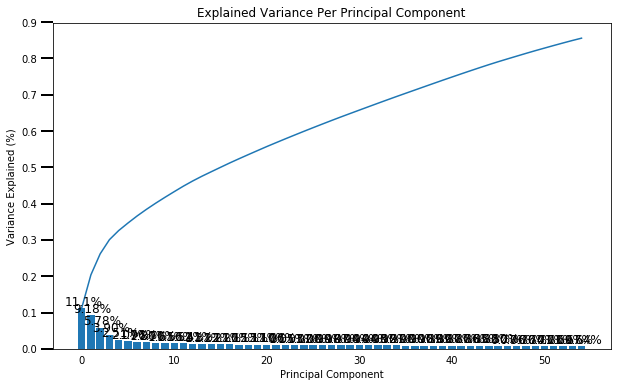

In [23]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca_dims)
#It seems like after 12th principal component explained variance drops significantly

In [24]:
for i in range(len(pca_dims.explained_variance_.cumsum())):
    vals=[]
    vals.append((i+1,pca_dims.explained_variance_.cumsum()[i]))
    print(vals)

[(1, 12.415834937033033)]
[(2, 22.615507749899727)]
[(3, 29.035863808405356)]
[(4, 33.368747916361855)]
[(5, 36.157201215627907)]
[(6, 38.457335646927092)]
[(7, 40.641027901206513)]
[(8, 42.648441111759546)]
[(9, 44.536707576778149)]
[(10, 46.327966113069124)]
[(11, 48.060307933371945)]
[(12, 49.755693185361118)]
[(13, 51.330700089814755)]
[(14, 52.787055053733994)]
[(15, 54.151207978506271)]
[(16, 55.502016221356484)]
[(17, 56.843079884372543)]
[(18, 58.125968378736943)]
[(19, 59.380413133243884)]
[(20, 60.619771699472729)]
[(21, 61.85186551854504)]
[(22, 63.035727222940977)]
[(23, 64.208697961591014)]
[(24, 65.360382769171366)]
[(25, 66.50294326605578)]
[(26, 67.623663359063798)]
[(27, 68.730493859958827)]
[(28, 69.827094763936046)]
[(29, 70.904355843077141)]
[(30, 71.956570586841494)]
[(31, 73.003739217743956)]
[(32, 74.048428495399165)]
[(33, 75.087873555455573)]
[(34, 76.118690672093393)]
[(35, 77.138899562964085)]
[(36, 78.143466161088952)]
[(37, 79.144090490443276)]
[(38, 80.144

In [25]:
# Re-apply PCA to the data while selecting for number of components to retain.
#To keep the 80% of variability in the dataset, I kept the first 38 components.
pca_model, X_pca = pca_func(azdias_cleaned_scaled, 38)

In [26]:
pca_model.components_.T[:3,:]

array([[-0.12302137,  0.22772204,  0.04395141, -0.03345065,  0.04302558,
         0.03908376, -0.06299505,  0.05328719, -0.09367942, -0.10027679,
        -0.01347977,  0.08031859, -0.01457989,  0.02904412,  0.00582437,
         0.02179312, -0.00279893,  0.00663987, -0.17333254,  0.03899943,
         0.00308294,  0.06000432,  0.02222363, -0.01950278, -0.03175817,
         0.01222423,  0.02820293,  0.03424863, -0.02913433,  0.03237124,
        -0.00619559,  0.03824532, -0.01365305,  0.00834636, -0.01814127,
         0.01264215, -0.04029084, -0.01181605],
       [ 0.00242613,  0.05869099, -0.36164627,  0.05984165, -0.02377932,
         0.00728051,  0.05935225,  0.00371987,  0.00294137,  0.00993882,
         0.07470735, -0.06678134,  0.02872598, -0.01183897,  0.00613579,
         0.00464217, -0.02975767, -0.0326713 ,  0.01087051,  0.00758642,
        -0.02168384,  0.0154232 , -0.01135488,  0.00437516,  0.01055683,
        -0.01133513, -0.01953657, -0.00708864,  0.01403119, -0.00689876,
   

In [27]:
X_pca[:3]

array([[ 4.18085512, -2.73677523, -3.00101799, -0.1067498 , -1.93121518,
         2.75387559, -0.81618227,  1.54252305, -0.13267148, -0.23448077,
        -1.22582744, -1.81949404, -0.97716288,  0.95116932, -0.80233509,
        -0.5836062 ,  0.26635458,  1.06697877,  2.17926048,  0.36628073,
         1.60318454,  1.08386179, -0.01744089,  0.50684195,  0.33562838,
         0.07148893, -1.21234848, -4.08575464, -2.86660283,  7.30367706,
        -1.33979387, -2.78008734,  3.38713191,  2.81456318, -0.36304167,
         2.91831824, -1.90741326, -2.13066368],
       [-0.37118575, -0.49819807, -3.22061751,  2.42216891, -2.51862872,
        -0.55302861,  0.73288332,  1.2159941 ,  0.53625215, -0.3686422 ,
        -1.4844401 ,  0.96836353, -0.70174523,  2.22343587, -0.08881303,
        -0.24312211,  2.00623775,  1.25160018, -1.66383911, -0.17994423,
        -1.19540147, -0.06505687, -0.61256539,  0.0540051 ,  0.33786904,
        -0.60890226,  0.32423666, -0.82668752, -1.62747492,  0.51912914,
   

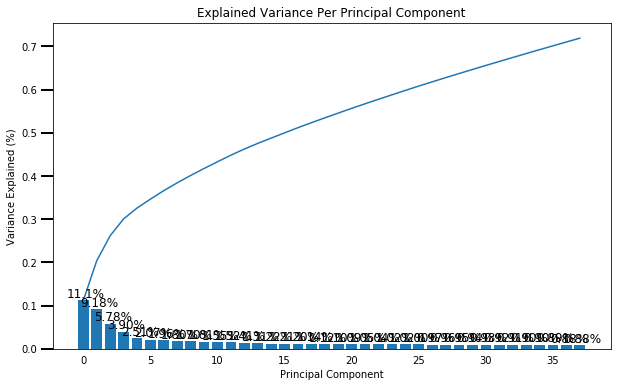

In [28]:
scree_plot(pca_model)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)
After filling the missing values with median values of the columns and rescaling the columns with standardscaler method and encoding the dummy variables, 111 columns created. Then to keep 80% of variability in the dataset, After applying PCA method, I reduced the dimensions to 38, which means almost 2/3 of the columns can be dropped for further analysis. 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [311]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
comp_1=pd.DataFrame(pca_model.components_[0])
comp_1.rename(columns={0:'First_Dim'}, inplace=True)
comp_1.index=azdias_cleaned_scaled.columns
comp_1.sort_values(by='First_Dim',ascending=False)


,First_Dim
PLZ8_ANTG3,0.204027
PLZ8_ANTG4,0.199057
PLZ8_BAUMAX,0.195040
HH_EINKOMMEN_SCORE,0.187202
wealth,0.185456
ORTSGR_KLS9,0.178403
EWDICHTE,0.176272
FINANZ_SPARER,0.149672
FINANZ_HAUSBAUER,0.145691
KBA05_ANTG4,0.139318


In [312]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#This is second dimension
comp_2=pd.DataFrame(pca_model.components_[1])
comp_2.rename(columns={0:'Second_Dim'}, inplace=True)
comp_2.index=azdias_cleaned_scaled.columns
comp_2.sort_values(by='Second_Dim',ascending=False)


,Second_Dim
ALTERSKATEGORIE_GROB,0.227722
FINANZ_VORSORGER,0.214800
ZABEOTYP_3,0.204834
SEMIO_ERL,0.187554
SEMIO_LUST,0.163795
RETOURTYP_BK_S,0.156411
W_KEIT_KIND_HH,0.127332
FINANZ_HAUSBAUER,0.119990
CJT_GESAMTTYP_2.0,0.107719
PLZ8_ANTG3,0.101183


In [313]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#This is third dimension
comp_3=pd.DataFrame(pca_model.components_[2])
comp_3.rename(columns={0:'Third_Dim'}, inplace=True)
comp_3.index=azdias_cleaned_scaled.columns
comp_3.sort_values(by='Third_Dim',ascending=False)


,Third_Dim
SEMIO_VERT,0.337332
SEMIO_SOZ,0.262400
SEMIO_FAM,0.260481
SEMIO_KULT,0.248636
FINANZ_MINIMALIST,0.146479
FINANZTYP_5,0.143095
SEMIO_REL,0.097734
RETOURTYP_BK_S,0.089228
SEMIO_MAT,0.078884
W_KEIT_KIND_HH,0.078389


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)
#### First Component:
PLZ8 is in the macro variables defining the family houses in the PLZ8 region. This dimension is positively correlated with variables about household wealth and negatively correlated with mobility of region and low financial interest of personal variables. First dimesnsion reflects household wealth and financial conditions.

#### Second Component:
Second component is about personal financial traits and age. It seems like this component moves in the direction of Age (and of course on the other direction of youth decade due to definition of the variable), and negatively whether the person is religous or not, and person's financial typology, energy and environmental consciousness.

#### Third Component:
Third component is about personality typologies (SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM	), financial attitudes and gender important variables correlated with this dimension.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [314]:
# Over a number of different cluster counts...

    # run k-means clustering on the data and...
kmeans_10=KMeans(10)
model_10=kmeans_10.fit(X_pca)
labels_10=model_10.predict(X_pca)
    # compute the average within-cluster distances.
np.abs(model_10.score(X_pca))
    

42721397.834673174

In [90]:
# Over a number of different cluster counts...

    # run k-means clustering on the data and...
kmeans_20=KMeans(20)
model_20=kmeans_20.fit(X_pca)
labels_20=model_20.predict(X_pca)
    # compute the average within-cluster distances.
np.abs(model_20.score(X_pca))
#AS RESULT SHOW, DISTANCE DROPPED, MORE CLUSTERS REDUCES THE DISTANCE AS EXPECTED   

38400840.81292361

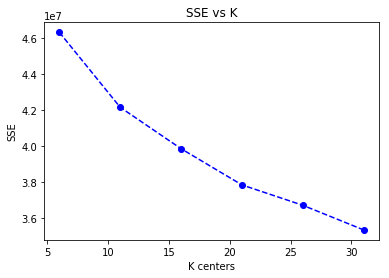

In [91]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
#I WILL USE SCREE PLOT that I wrote in UDACITY course before
fit_scores=[]
center_k=[]
for k in range(5, 31, 5):
    model=KMeans(k+1)
    est = model.fit(X_pca)
    label = est.predict(X_pca)
    fit_scores.append(np.abs(est.score(X_pca)))
    center_k.append(k+1)
plt.plot(center_k, fit_scores, linestyle='--', marker='o', color='b');
plt.xlabel('K centers');
plt.ylabel('SSE');
plt.title('SSE vs K');

#Because it didn't make any significant elbow I ran 1 more iteration



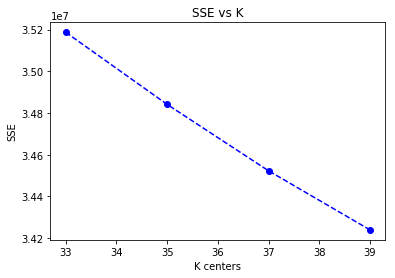

In [92]:
fit_scores=[]
center_k=[]
for k in range(32, 39, 2):
    model=KMeans(k+1)
    est = model.fit(X_pca)
    label = est.predict(X_pca)
    fit_scores.append(np.abs(est.score(X_pca)))
    center_k.append(k+1)
plt.plot(center_k, fit_scores, linestyle='--', marker='o', color='b');
plt.xlabel('K centers');
plt.ylabel('SSE');
plt.title('SSE vs K');


In [29]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data

#NOTE THAT you can see from the second chart that clusters above 30 did not drop distance as much as the initial clusters. 
#First chart shows that after about 30 clusters, the drop in the distance does not improve as initial ones
#hence cluster number is selected as 30. 
#The first chart drops about 0.4e7 per 10 cluster whereas after 30 cluster this becomes 0.2e7, which shows the slowdown
kmeans_30=KMeans(30)
model_30=kmeans_30.fit(X_pca)
labels_30=model_30.predict(X_pca)
    # compute the average within-cluster distances.
np.abs(model_30.score(X_pca))

35685337.164770022

In [30]:
general_clusters, general_clusters_counted=np.unique(labels_30, return_counts=True)

<Container object of 30 artists>

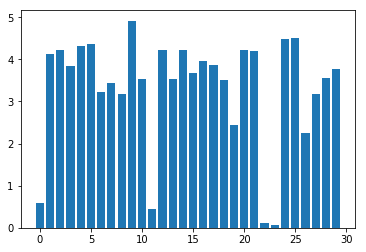

In [31]:
plt.bar(general_clusters, general_clusters_counted/len(labels_30)*100)

In [32]:
Population_df=pd.DataFrame(np.array(list(zip(general_clusters, general_clusters_counted, general_clusters_counted/len(labels_30)*100))),
             columns=["Population_Cluster_No","Counted_Cluster","Population_Cluster_Percent"])
Population_df

,Population_Cluster_No,Counted_Cluster,Population_Cluster_Percent
0,0.0,4692.0,0.592210
1,1.0,32662.0,4.122496
2,2.0,33493.0,4.227382
3,3.0,30390.0,3.835731
4,4.0,34202.0,4.316870
5,5.0,34646.0,4.372910
6,6.0,25642.0,3.236453
7,7.0,27162.0,3.428303
8,8.0,25253.0,3.187355
9,9.0,38966.0,4.918167


### Discussion 3.1: Apply Clustering to General Population

As my analysis show, the distance reduces as the number of clusters increase.This has been shown by using K-means algorithm with 10 clusters first, and then 20 clusters. To find the optimal number of clusters, from 5 to 39 number of classes have been tried. It has been shown that after 30 classes the distance did not show a meaningful drop to justify increased cost of calculation. Also, except a few instance, generally each class contains 2-4% of the observations, showing near uniform distribution in terms of number of observations.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [47]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', header='infer', delimiter=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', header='infer', delimiter=';')

In [48]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
from sklearn.preprocessing.imputation import Imputer
customers_cleaned=clean_data(customers)
imputer= Imputer(strategy='median',missing_values=np.nan, verbose=0)
imputer.fit(customers_cleaned)
X_cust=imputer.transform(customers_cleaned)
customers_cleaned_filled = pd.DataFrame(data=X_cust, columns=customers_cleaned.columns, index=customers_cleaned.index)

Total number of NaNs is 3112918
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
After dropping columns with 33% or higher NaNs,new size is (191652, 79)
After removing rows with 33% or more missing features,new size is (140898, 79)
After generating mixed features, creating dummy variables, and dropping other columns the final size is (140898, 110)


In [49]:
#Now let's rescale data 
from sklearn.preprocessing import StandardScaler
customers_cleaned_scaled =  StandardScaler().fit_transform(customers_cleaned_filled)
customers_cleaned_scaled = pd.DataFrame(data=customers_cleaned_scaled, columns=customers_cleaned.columns, index=customers_cleaned.index)

In [50]:
customers_cleaned_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,youth_decade,youth_movement,wealth,life_stage
0,0.700922,-0.702753,0.721736,-0.515742,0.515274,-0.599984,0.144755,-0.557040,1.003042,-1.258214,0.921136,1.029580,0.660341,-0.813319,1.271748,0.459469,0.904873,-1.069457,0.048725,-1.348617,-0.513389,-1.887248,-1.448127,-0.715538,-1.371802,-0.0996,-0.974519,-0.196257,-0.133906,-1.360698,0.919012,0.299224,-0.277748,-0.122647,1.292007,-0.344212,0.294787,1.564718,-0.146932,0.749141,-0.396133,-0.314872,0.309774,-0.615617,-1.170356,-0.400091,0.177380,-1.424938,0.284510,0.019839,-1.579759,1.573521,0.506334,0.316649,-0.435468,-0.836863,-0.465256,1.478176,1.369476,-1.811817,-1.447233,-1.339032,-0.634000,-0.439282,-0.464092,2.695776,-0.278237,1.540961,-0.177658,-0.113884,-0.701863,-0.657903,-0.183152,-0.329935,2.853020,-0.359052,-0.211393,-0.319221,-0.363183,-0.194246,-0.469494,-0.228559,-0.222741,2.045408,-0.103278,-0.243442,-0.821756,-0.401834,-0.354197,-0.540460,1.317167,-0.130039,-0.099999,-0.592175,-0.443197,1.371365,-0.225170,1.173979,-0.340168,-0.082826,-0.195188,-0.119661,-0.447751,-0.041991,-0.031538,-0.411894,-0.661339,0.986437,-1.137360,-0.276451
2,0.700922,1.422976,0.721736,-0.515742,0.515274,-0.599984,2.198078,0.962326,1.003042,0.046552,0.921136,-1.441233,-1.125903,-1.498848,-0.242127,-1.244739,0.904873,1.214323,-1.663035,-0.633473,1.738473,0.627131,1.339158,0.680107,-1.371802,-0.0996,1.026148,-0.914700,-0.133906,-1.360698,0.919012,0.299224,-0.277748,-0.122647,-1.485425,-0.344212,0.294787,-0.826906,-0.146932,0.749141,-0.396133,-0.314872,-0.560980,1.276341,0.073850,-1.929928,-1.028009,0.617222,-0.509022,-1.467764,1.596901,-0.688434,-0.604765,0.316649,1.837841,0.736161,1.231069,-0.672628,-1.624310,0.173673,-0.055160,0.071636,1.577287,-0.439282,-0.464092,-0.370951,-0.278237,1.540961,-0.177658,-0.113884,-0.701863,-0.657903,-0.183152,3.030904,-0.350506,-0.359052,-0.211393,-0.319221,-0.363183,-0.194246,-0.469494,-0.228559,-0.222741,-0.488900,-0.103278,-0.243442,-0.821756,-0.401834,-0.354197,-0.540460,1.317167,-0.130039,-0.099999,1.688689,-0.443197,-0.729200,-0.225170,1.173979,-0.340168,-0.082826,-0.195188,-0.119661,-0.447751,-0.041991,-0.031538,2.427810,-0.661339,0.986437,0.287360,0.470502
3,0.700922,-0.702753,0.721736,-0.515742,0.515274,0.398393,-0.881907,-0.557040,-0.996967,0.046552,-0.783706,1.029580,0.660341,-0.127790,0.262498,1.027539,-0.321386,-1.069457,0.048725,0.081672,-0.513389,-0.630058,-0.333213,-0.017716,0.785058,-0.0996,-0.974519,-1.633144,-0.133906,0.449315,0.375146,0.299224,-0

In [51]:
customers_cleaned_scaled['GEBAEUDETYP_5.0']=0

In [52]:
#This will make sure columns in same order
cust_names=customers_cleaned_scaled.columns.tolist()
population_names=azdias_cleaned_scaled.columns.tolist()
customers_cleaned_scaled=customers_cleaned_scaled.reindex(columns=population_names)
cust_names=customers_cleaned_scaled.columns.tolist()

In [53]:
pca_cust = pca_model.transform(customers_cleaned_scaled)

In [54]:
cust_labels_30 = kmeans_30.predict(pca_cust)

In [55]:
cust_clusters, cust_clusters_counted=np.unique(cust_labels_30, return_counts=True)

<Container object of 30 artists>

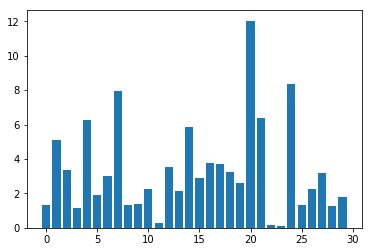

In [56]:
plt.bar(cust_clusters, cust_clusters_counted/len(pca_cust)*100)

In [43]:
#cust_df=pd.DataFrame(np.array(list(zip(cust_clusters, cust_clusters_counted, cust_clusters_counted/len(pca_cust)*100))),
#             columns=["Customer_Cluster_No","Counted_Cluster","Customer_Cluster_Percent"])
#to_append = {'Customer_Cluster_No':26,'Counted_Cluster':0,'Customer_Cluster_Percent':0}
#cust_df2 = cust_df.append(to_append, ignore_index=True)

In [44]:
#cust_df2=cust_df2.sort_values(by='Customer_Cluster_No')

In [57]:
cust_df=pd.DataFrame(np.array(list(zip(cust_clusters, cust_clusters_counted, cust_clusters_counted/len(pca_cust)*100))),
             columns=["Customer_Cluster_No","Counted_Cluster","Customer_Cluster_Percent"])
cust_df

,Customer_Cluster_No,Counted_Cluster,Customer_Cluster_Percent
0,0.0,1873.0,1.329330
1,1.0,7209.0,5.116467
2,2.0,4759.0,3.377621
3,3.0,1587.0,1.126347
4,4.0,8820.0,6.259848
5,5.0,2654.0,1.883632
6,6.0,4276.0,3.034820
7,7.0,11211.0,7.956820
8,8.0,1899.0,1.347784
9,9.0,1925.0,1.366237


In [58]:
comparison_df= pd.merge(Population_df, cust_df, how='left', 
                        left_on=Population_df['Population_Cluster_No'], right_on=cust_df['Customer_Cluster_No'])

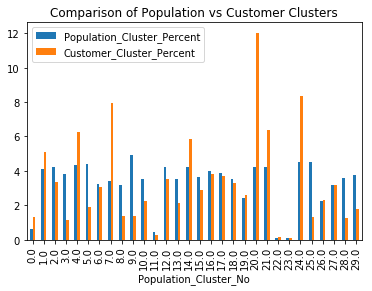

In [60]:
comparison_df.plot(x="Population_Cluster_No", y=['Population_Cluster_Percent','Customer_Cluster_Percent'], 
                   kind="bar", title='Comparison of Population vs Customer Clusters')

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

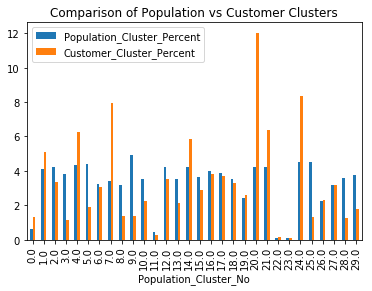

In [61]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
##compare clusters:
comparison_df.plot(x="Population_Cluster_No", y=['Population_Cluster_Percent','Customer_Cluster_Percent'], 
                   kind="bar", title='Comparison of Population vs Customer Clusters')

As the chart shows above, the minimal clusters, such as 0, 11, 22, and 23, are in similar proportions both in population and customer datasets.
While the rest of the clusters generally follows similar pattern in both dataset, usually between 2-4% of the total observations, there are certain clusters in the customer dataset that significantly differs from population dataset. These clusters are 1,4, 7,14, 20, 21, and 24. Especially 20, 24,7, and 4 significantly overrepresented in customer dataset. Also, 5,8,9,10,25,28, and 29 significantly underrepresented in customer dataset.

In [82]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
customers_clusters=customers_cleaned_scaled.copy()
customers_clusters['cluster']=cust_labels_30

In [94]:
customers_clusters[customers_clusters['cluster'].isin([20,24])].describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,youth_decade,youth_movement,wealth,life_stage,cluster
count,28708.000000,2.870800e+04,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,2.870800e+04,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,2.870800e+04,28708.000000,28708.000000,28708.000000,28708.000000,28708.0,2.870800e+04,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000,28708.000000
mean,0.346492,-7.027526e-01,0.685146,-0.330359,0.310624,-0.282019,-0.235934,-0.560534,0.307135,-0.138882,0.123558,0.336030,0.276333,0.199858,0.009957,0.607047,0.225386,-0.458856,0.473982,-0.501345,-0.589652,-0.517621,-0.714683,-0.204398,-0.060391,-0.022602,-0.194546,0.267148,-0.009866,-0.610561,-0.042908,0.210856,-0.261009,-0.083472,0.370776,-0.095705,0.125511,0.055499,0.621377,-0.273882,-0.370601,-0.307740,0.506292,0.150511,-0.279025,0.207215,0.275800,-0.095983,0.607887,0.155395,-0.176756,0.041707,0.511171,-0.434967,-0.472568,-0.401744,-0.425785,-0.128709,0.256696,-0.204952,-0.283552,-0.219264,-0.043435,0.143726,0.007623,0.027826,-0.187459,-0.024501,-0.173613,-1.138844e-01,0.194560,-0.020576,-0.114943,0.003831,-0.025109,0.058229,0.045962,0.149595,-0.034021,-0.044627,0.056318,-0.079900,-0.176944,0.130641,-0.071917,-0.108092,0.245012,-0.383006,0.036293,0.195715,0.375971,-0.063302,-0.058132,-0.316959,-0.127806,0.118109,-0.119192,-0.297021,

For analysis, clusters 20 and 24 are chosen.In both of these overrepresented customer clusters, wealthy households are more likely here and usually household net income is high/top earnes, and elder generation. Also more female customer in this cluster (Note that the way wealth coded is as following:1 is wealthy whereas 5 is poorer households, hence positive mean shows less weathly subset of cluster)

In [95]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
customers_clusters[customers_clusters['cluster'].isin([9,25])].describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,youth_decade,youth_movement,wealth,life_stage,cluster
count,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3.798000e+03,3798.0,3.798000e+03,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000
mean,-1.821609,1.204134,-1.568171,1.633144,-1.358170,1.508227,1.118434,0.374061,-0.428771,0.464984,-0.617396,-0.773762,-0.318848,0.747080,0.277911,-1.349288,-0.937745,0.130760,-0.298765,1.710423,0.869716,1.264995,1.166402,1.437827,1.064841,-0.024847,-0.149073,-0.317511,-0.075199,0.589586,-0.247193,-0.683527,-0.017480,-0.061482,-0.280445,-0.000375,-0.021692,-0.043552,-0.424972,0.566433,0.420898,-0.177857,-0.227168,-0.033658,0.152473,-0.047371,-0.128251,-0.048173,-0.358589,0.317124,-0.025861,0.196111,-0.265116,0.367394,0.270527,0.122359,0.048376,0.239113,0.101702,0.056572,0.101714,0.067550,-0.235177,0.019058,0.256467,0.125636,0.201976,-0.282232,-0.023247,0.452867,-0.526602,-0.017383,0.044176,-0.102516,-0.197836,-0.102419,-0.087781,-0.198343,-0.035766,0.215081,-0.015035,0.170242,0.516731,-0.135912,0.252292,0.118585,-0.296792,0.578383,-0.105720,-0.278599,-0.472734,0.269403,0.469096,-0.145971,0.489342,-0.274022,-0.039649,-0.355226,0.688360,1.005415,0.496573,-0.068328,0.061934,-4.199098e-02,0.0,-3.153752e-02,0.153355,1.109720,-0.340701,0.301239,-0.234

In [ ]:
For analysis, clusters 9 and 25 are chosen for underrepresented clusters.
In both of these underrepresented customer clusters, wealth is toward less affluent/poorer households,
usually household net income is low, younger generation and more male proportion in this clusters.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [ ]:
It becomes clear that the company should target wealthy and elderly population.